Data Preparation

In [2]:
# Download MovieLens dataset
import os
import urllib.request
import zipfile

# Load ratings and movies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Using the Surprise library for collaborative filtering
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import cross_validate

# Content-Based Filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import pickle
from scipy import stats

import random
import time
import polars as pl
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Download dataset if not already present
dataset_url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
if not os.path.exists('ml-latest-small'):
    print("Downloading MovieLens dataset...")
    urllib.request.urlretrieve(dataset_url, 'ml-latest-small.zip')
    with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Download complete!")

In [4]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')

# Display basic info
print(f"Total ratings: {len(ratings)}")
print(f"Unique users: {ratings['userId'].nunique()}")
print(f"Unique movies: {ratings['movieId'].nunique()}")

Total ratings: 100836
Unique users: 610
Unique movies: 9724


In [5]:
# Create train/test split
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

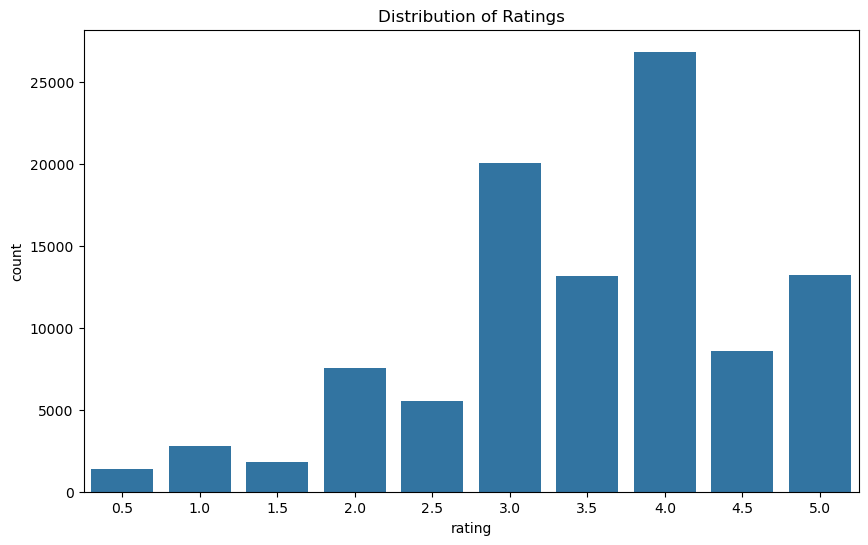

In [6]:
# Visualize ratings distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.savefig('rating_distribution.png')
plt.show()

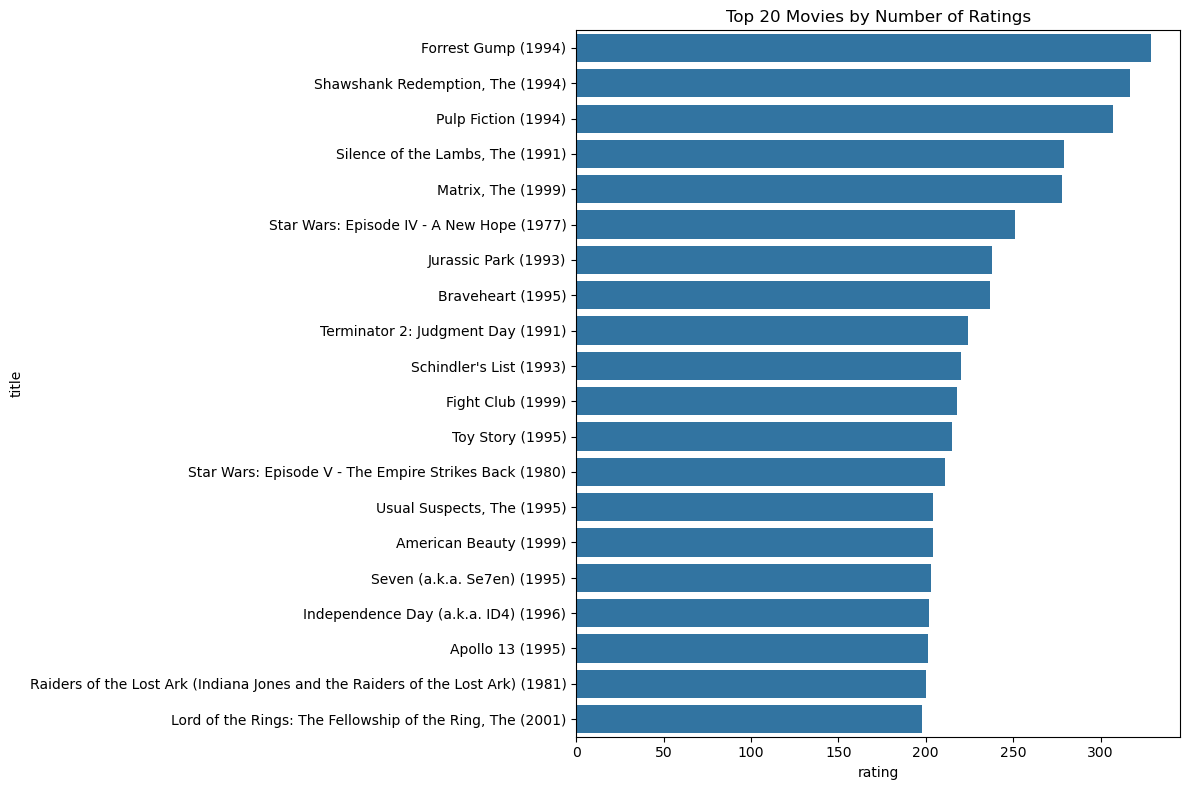

In [7]:
# Show top rated movies
top_movies = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False).head(20)
top_movies = top_movies.reset_index().merge(movies[['movieId', 'title']], on='movieId')

plt.figure(figsize=(12, 8))
sns.barplot(x='rating', y='title', data=top_movies)
plt.title('Top 20 Movies by Number of Ratings')
plt.tight_layout()
plt.savefig('top_movies.png')
plt.show()

Recommendation Models 

In [9]:
# Define reader and load data
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [10]:
# Build and evaluate User-Based Collaborative Filtering
print("Training user-based collaborative filtering model...")
user_based = KNNBasic(k=50, sim_options={'name': 'pearson', 'user_based': True})
user_based_cv = cross_validate(user_based, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Training user-based collaborative filtering model...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9759  0.9676  0.9683  0.9760  0.9744  0.9724  0.0037  
MAE (testset)     0.7536  0.7456  0.7455  0.7557  0.7531  0.7507  0.0043  
Fit time          0.27    0.27    0.28    0.29    0.28    0.28    0.01    
Test time         0.78    0.82    0.75    0.82    0.72    0.78    0.04    


In [11]:
# Build and evaluate Item-Based Collaborative Filtering
print("\nTraining item-based collaborative filtering model...")
item_based = KNNBasic(k=50, sim_options={'name': 'pearson', 'user_based': False})
item_based_cv = cross_validate(item_based, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Training item-based collaborative filtering model...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9652  0.9695  0.9607  0.9610  0.9760  0.9665  0.0057  
MAE (testset)     0.7484  0.7528  0.7455  0.7462  0.7561  0.7498  0.0041  
Fit time          11.87   10.35   9.11    8.58    9.71    9.92    1.14    
Test time         4.59    4.82    4.64    5.35    4.68    4.82    0.28    


In [12]:
# Build and evaluate Matrix Factorization (SVD)
print("\nTraining SVD model...")
svd = SVD()
svd_cv = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Training SVD model...
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8657  0.8730  0.8744  0.8751  0.8844  0.8745  0.0060  
MAE (testset)     0.6656  0.6711  0.6733  0.6703  0.6797  0.6720  0.0046  
Fit time          0.77    0.76    0.74    0.75    0.75    0.75    0.01    
Test time         0.27    0.09    0.08    0.08    0.08    0.12    0.08    


In [13]:
# Train the final models on the full dataset
trainset = data.build_full_trainset()
user_based.fit(trainset)
item_based.fit(trainset)
svd.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [14]:
# Extract genres and create a TF-IDF matrix
movies['genres'] = movies['genres'].str.replace('|', ' ')
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# Compute cosine similarity between movies
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get movie recommendations based on similarity
def get_content_recommendations(movie_id, cosine_sim=cosine_sim, movies=movies, n=10):
    # Get the index of the movie
    idx = movies.index[movies['movieId'] == movie_id].tolist()[0]
    
    # Get similarity scores with other movies
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get top N most similar movies (excluding the input movie)
    sim_scores = sim_scores[1:n+1]
    
    # Get movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Return recommended movies
    return movies.iloc[movie_indices][['movieId', 'title', 'genres']]

# Test the content-based recommender
test_movie_id = 1  # Toy Story
content_recommendations = get_content_recommendations(test_movie_id)
print(f"\nContent-based recommendations for {movies[movies['movieId'] == test_movie_id]['title'].values[0]}:")
print(content_recommendations)


Content-based recommendations for Toy Story (1995):
      movieId                                              title  \
1706     2294                                        Antz (1998)   
2355     3114                                 Toy Story 2 (1999)   
2809     3754     Adventures of Rocky and Bullwinkle, The (2000)   
3000     4016                   Emperor's New Groove, The (2000)   
3568     4886                              Monsters, Inc. (2001)   
6194    45074                                   Wild, The (2006)   
6486    53121                             Shrek the Third (2007)   
6948    65577                     Tale of Despereaux, The (2008)   
7760    91355  Asterix and the Vikings (Astérix et les Viking...   
8219   103755                                       Turbo (2013)   

                                           genres  
1706  Adventure Animation Children Comedy Fantasy  
2355  Adventure Animation Children Comedy Fantasy  
2809  Adventure Animation Children Comedy 

In [15]:
# Save models
os.makedirs('model', exist_ok=True)
pickle.dump(user_based, open('model/user_based_model.pkl', 'wb'))
pickle.dump(item_based, open('model/item_based_model.pkl', 'wb'))
pickle.dump(svd, open('model/svd_model.pkl', 'wb'))
pickle.dump(cosine_sim, open('model/content_sim_matrix.pkl', 'wb'))

A/B Testing Framework

In [17]:
# A/B testing framework
class ABTestFramework:
    def __init__(self, model_a, model_b, test_data):
        self.model_a = model_a  # Algorithm A (e.g., user-based)
        self.model_b = model_b  # Algorithm B (e.g., SVD)
        self.test_data = test_data
        self.results_a = []
        self.results_b = []
        
    def simulate_user_interactions(self, n_samples=1000):
        # Randomly sample user-item pairs from test data
        samples = self.test_data.sample(n_samples, replace=True)
        
        for _, row in samples.iterrows():
            user_id = row['userId']
            movie_id = row['movieId']
            actual_rating = row['rating']
            
            # Get predictions from both models
            try:
                pred_a = self.model_a.predict(user_id, movie_id).est
                pred_b = self.model_b.predict(user_id, movie_id).est
                
                # Simulate click-through based on prediction accuracy
                # (closer prediction = higher chance of click)
                error_a = abs(pred_a - actual_rating)
                error_b = abs(pred_b - actual_rating)
                
                # Convert errors to click probabilities (smaller error = higher probability)
                p_click_a = max(0, 1 - (error_a / 5))
                p_click_b = max(0, 1 - (error_b / 5))
                
                # Simulate user clicks
                click_a = np.random.random() < p_click_a
                click_b = np.random.random() < p_click_b
                
                self.results_a.append(click_a)
                self.results_b.append(click_b)
            except:
                # Skip if prediction fails
                continue
    
    def calculate_metrics(self):
        # Calculate CTR for both models
        ctr_a = np.mean(self.results_a)
        ctr_b = np.mean(self.results_b)
        
        # Perform statistical significance test
        t_stat, p_value = stats.ttest_ind(self.results_a, self.results_b)
        
        return {
            'ctr_a': ctr_a,
            'ctr_b': ctr_b,
            'lift': (ctr_b - ctr_a) / ctr_a if ctr_a > 0 else 0,
            'p_value': p_value,
            'is_significant': p_value < 0.05,
            'winner': 'B' if ctr_b > ctr_a and p_value < 0.05 else 'A' if ctr_a > ctr_b and p_value < 0.05 else 'No clear winner'
        }

# Run A/B test simulation
print("Running A/B test simulation...")
ab_test = ABTestFramework(user_based, svd, test_data)
ab_test.simulate_user_interactions(n_samples=5000)
results = ab_test.calculate_metrics()

Running A/B test simulation...


In [18]:
print("\nA/B Test Results:")
print(f"CTR Model A (User-based): {results['ctr_a']:.4f}")
print(f"CTR Model B (SVD): {results['ctr_b']:.4f}")
print(f"Lift: {results['lift']:.2%}")
print(f"p-value: {results['p_value']:.4f}")
print(f"Statistically Significant: {results['is_significant']}")
print(f"Winner: {results['winner']}")


A/B Test Results:
CTR Model A (User-based): 0.9068
CTR Model B (SVD): 0.8942
Lift: -1.39%
p-value: 0.0353
Statistically Significant: True
Winner: A


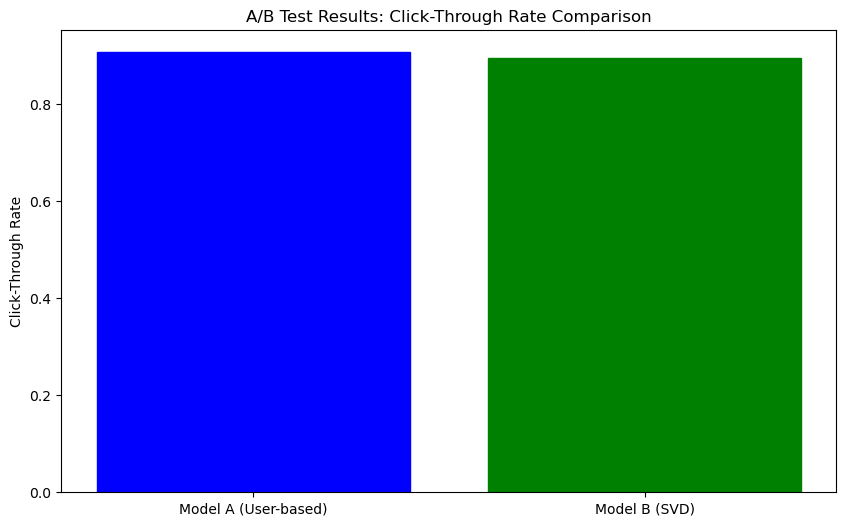

In [19]:
# Visualize A/B test results
plt.figure(figsize=(10, 6))
bars = plt.bar(['Model A (User-based)', 'Model B (SVD)'], [results['ctr_a'], results['ctr_b']])
bars[0].set_color('blue')
bars[1].set_color('green')
plt.title('A/B Test Results: Click-Through Rate Comparison')
plt.ylabel('Click-Through Rate')
plt.savefig('ab_test_results.png')
plt.show()

Big Data Processing

In [21]:
print("Starting big data simulation with Polars...")

# Generate synthetic data first with pandas
def generate_synthetic_data(n_users=10000, n_items=2000, n_interactions=500000):
    print("Generating synthetic data...")
    interactions = []
    for _ in range(n_interactions):
        user_id = random.randint(1, n_users)
        item_id = random.randint(1, n_items)
        rating_options = [3, 3.5, 4, 4.5, 5]
        weights = [0.15, 0.2, 0.35, 0.2, 0.1]
        rating = random.choices(rating_options, weights=weights)[0]
        timestamp = random.randint(1546300800, 1609459200)
        interactions.append((user_id, item_id, rating, timestamp))
    
    return interactions

# Generate and save data
start_time = time.time()
synthetic_data = generate_synthetic_data()
synthetic_df = pd.DataFrame(synthetic_data, columns=['userId', 'itemId', 'rating', 'timestamp'])
synthetic_df.to_csv('synthetic_interactions.csv', index=False)
print(f"Data generation completed in {time.time() - start_time:.2f} seconds")

Starting big data simulation with Polars...
Generating synthetic data...
Data generation completed in 2.62 seconds


In [22]:
# Load with Polars
df = pl.read_csv('synthetic_interactions.csv')

# Print basic statistics
print("\nSynthetic data statistics:")
print(f"Total interactions: {len(df)}")
print(f"Unique users: {df['userId'].n_unique()}")
print(f"Unique items: {df['itemId'].n_unique()}")


Synthetic data statistics:
Total interactions: 500000
Unique users: 10000
Unique items: 2000


In [23]:
# Demonstrate fast aggregations
print("\nComputing aggregates with Polars...")
start_time = time.time()
user_stats = df.group_by('userId').agg([
    pl.col('rating').mean().alias('avg_rating'),
    pl.col('rating').std().alias('std_rating'),
    pl.col('rating').count().alias('n_ratings')
])
print(f"Computation completed in {time.time() - start_time:.2f} seconds")
print(f"Sample of user statistics:\n{user_stats.head()}")


Computing aggregates with Polars...
Computation completed in 0.04 seconds
Sample of user statistics:
shape: (5, 4)
┌────────┬────────────┬────────────┬───────────┐
│ userId ┆ avg_rating ┆ std_rating ┆ n_ratings │
│ ---    ┆ ---        ┆ ---        ┆ ---       │
│ i64    ┆ f64        ┆ f64        ┆ u32       │
╞════════╪════════════╪════════════╪═══════════╡
│ 3284   ┆ 3.877778   ┆ 0.565641   ┆ 45        │
│ 1974   ┆ 3.836538   ┆ 0.647175   ┆ 52        │
│ 3287   ┆ 3.973684   ┆ 0.570253   ┆ 57        │
│ 8003   ┆ 4.089744   ┆ 0.594623   ┆ 39        │
│ 5130   ┆ 3.845238   ┆ 0.535201   ┆ 42        │
└────────┴────────────┴────────────┴───────────┘


In [24]:
# Show fast filtering and joining
print("\nDemonstrating fast joins and filters...")
start_time = time.time()
# Find active users (more than 10 ratings)
active_users = user_stats.filter(pl.col('n_ratings') > 10)

# Join back to get all ratings from active users
active_ratings = df.join(active_users.select('userId'), on='userId', how='inner')

print(f"Join and filter completed in {time.time() - start_time:.2f} seconds")
print(f"Original dataset: {len(df)} rows")
print(f"After filtering to active users: {len(active_ratings)} rows")

# Create user-item matrix for collaborative filtering
print("\nCreating user-item matrix...")
start_time = time.time()

# First identify top users and items to keep matrix manageable
top_users = user_stats.sort('n_ratings', descending=True).head(1000)['userId']
top_items = df.group_by('itemId').agg(
    pl.col('rating').count().alias('count')
).sort('count', descending=True).head(2000)['itemId']

# Filter data to only include top users and items
filtered_df = df.filter(
    pl.col('userId').is_in(top_users) & 
    pl.col('itemId').is_in(top_items)
)

# Convert to pandas for matrix operations
filtered_pd = filtered_df.to_pandas()

# Create a pivot table (user-item matrix)
user_item_matrix = filtered_pd.pivot_table(
    index='userId', 
    columns='itemId', 
    values='rating', 
    fill_value=0
)

print(f"User-item matrix creation completed in {time.time() - start_time:.2f} seconds")
print(f"Matrix shape: {user_item_matrix.shape}")

# Calculate similarity between items
print("\nCalculating item similarity matrix...")
start_time = time.time()

# Transpose for item-based similarity
item_matrix = user_item_matrix.T

# To efficiently handle large matrices, we'll use a smaller subset for demo
if item_matrix.shape[0] > 500:
    item_matrix_sample = item_matrix.iloc[:500, :500]
else:
    item_matrix_sample = item_matrix

# Calculate cosine similarity
item_similarity = cosine_similarity(item_matrix_sample)

# Convert to dataframe with item IDs
item_ids = item_matrix_sample.index.tolist()
item_sim_df = pd.DataFrame(item_similarity, index=item_ids, columns=item_ids)

print(f"Item similarity calculation completed in {time.time() - start_time:.2f} seconds")
print(f"Sample of item similarity matrix:\n{item_sim_df.iloc[:5, :5]}")

# Demonstrate memory-efficient batch processing
print("\nDemonstrating batch processing for predictions...")
start_time = time.time()

# Function to generate predictions using item-based CF
def predict_ratings(user_id, item_ids, item_sim_df, user_item_matrix, n_similar=10):
    """Predict ratings for a user and list of items using item-based CF"""
    if user_id not in user_item_matrix.index:
        return {}
    
    user_ratings = user_item_matrix.loc[user_id]
    predictions = {}
    
    for item_id in item_ids:
        if item_id not in item_sim_df.columns:
            continue
            
        # Find similar items the user has rated
        similar_items = item_sim_df[item_id].sort_values(ascending=False)[1:n_similar+1]
        
        # Get ratings for these items
        sim_item_ratings = user_ratings[similar_items.index]
        
        # Only consider items the user has actually rated
        valid_ratings = sim_item_ratings[sim_item_ratings > 0]
        
        if len(valid_ratings) > 0:
            # Calculate weighted average
            item_sims = similar_items[valid_ratings.index]
            weighted_sum = (valid_ratings * item_sims).sum()
            sim_sum = item_sims.sum()
            
            if sim_sum > 0:
                predictions[item_id] = weighted_sum / sim_sum
    
    return predictions

# Batch process predictions for sample users
sample_users = top_users.to_list()[:5]
unrated_items = {}

# Get unrated items for each user
for user_id in sample_users:
    rated_items = set(filtered_df.filter(pl.col('userId') == user_id)['itemId'].to_list())
    all_items = set(top_items.to_list())
    unrated_items[user_id] = list(all_items - rated_items)[:20]  # Limit to 20 for demo

# Process in batches
all_predictions = {}
batch_size = 2
for i in range(0, len(sample_users), batch_size):
    batch_users = sample_users[i:i+batch_size]
    print(f"Processing batch {i//batch_size + 1}: Users {batch_users}")
    
    batch_start = time.time()
    for user_id in batch_users:
        all_predictions[user_id] = predict_ratings(
            user_id, 
            unrated_items[user_id], 
            item_sim_df, 
            user_item_matrix
        )
    print(f"  Batch completed in {time.time() - batch_start:.2f} seconds")

print(f"Batch prediction completed in {time.time() - start_time:.2f} seconds")


Demonstrating fast joins and filters...
Join and filter completed in 0.03 seconds
Original dataset: 500000 rows
After filtering to active users: 500000 rows

Creating user-item matrix...
User-item matrix creation completed in 0.10 seconds
Matrix shape: (1000, 2000)

Calculating item similarity matrix...
Item similarity calculation completed in 0.13 seconds
Sample of item similarity matrix:
          1         2         3         4         5
1  1.000000  0.134977  0.055705  0.114231  0.085464
2  0.134977  1.000000  0.000000  0.060597  0.137989
3  0.055705  0.000000  1.000000  0.093202  0.117547
4  0.114231  0.060597  0.093202  1.000000  0.000000
5  0.085464  0.137989  0.117547  0.000000  1.000000

Demonstrating batch processing for predictions...
Processing batch 1: Users [8408, 2821]
  Batch completed in 0.02 seconds
Processing batch 2: Users [8988, 1598]
  Batch completed in 0.01 seconds
Processing batch 3: Users [7098]
  Batch completed in 0.01 seconds
Batch prediction completed in 

In [25]:
# Print sample predictions
for user_id in sample_users:
    if user_id in all_predictions and all_predictions[user_id]:
        top_preds = sorted(all_predictions[user_id].items(), key=lambda x: x[1], reverse=True)[:3]
        print(f"\nTop 3 predictions for user {user_id}:")
        for item_id, rating in top_preds:
            print(f"  Item {item_id}: Predicted rating {rating:.2f}")

# Save processed data and models for later use in the recommendation API
print("\nSaving processed data and models...")
try:
    # Save item similarity matrix
    with open('model/item_similarity.pkl', 'wb') as f:
        pickle.dump(item_sim_df, f)
    
    # Save user-item matrix
    with open('model/user_item_matrix.pkl', 'wb') as f:
        pickle.dump(user_item_matrix, f)
    
    # Save user stats
    user_stats_pd = user_stats.to_pandas()
    with open('model/user_stats.pkl', 'wb') as f:
        pickle.dump(user_stats_pd, f)
    
    print("Data and models saved successfully!")
except Exception as e:
    print(f"Error saving data: {str(e)}")
    print("Creating model directory and trying again...")
    import os
    os.makedirs('model', exist_ok=True)
    
    # Save item similarity matrix
    with open('model/item_similarity.pkl', 'wb') as f:
        pickle.dump(item_sim_df, f)
    
    # Save user-item matrix
    with open('model/user_item_matrix.pkl', 'wb') as f:
        pickle.dump(user_item_matrix, f)
    
    # Save user stats
    user_stats_pd = user_stats.to_pandas()
    with open('model/user_stats.pkl', 'wb') as f:
        pickle.dump(user_stats_pd, f)
    
    print("Data and models saved successfully on second attempt!")

print("\nBig data processing completed successfully!")


Top 3 predictions for user 8408:
  Item 13: Predicted rating 4.25
  Item 16: Predicted rating 4.22
  Item 21: Predicted rating 4.01

Top 3 predictions for user 2821:
  Item 18: Predicted rating 4.50
  Item 19: Predicted rating 3.52
  Item 8: Predicted rating 3.50

Top 3 predictions for user 8988:
  Item 2: Predicted rating 4.00
  Item 7: Predicted rating 4.00
  Item 10: Predicted rating 4.00

Top 3 predictions for user 1598:
  Item 3: Predicted rating 4.00
  Item 4: Predicted rating 4.00
  Item 15: Predicted rating 4.00

Top 3 predictions for user 7098:
  Item 10: Predicted rating 4.50
  Item 11: Predicted rating 4.00
  Item 19: Predicted rating 4.00

Saving processed data and models...
Data and models saved successfully!

Big data processing completed successfully!
